# Importing ODV aggregated spreadsheet data

* Data are supposed to be aggregated using ODV and exported as aggregated ODV spreadsheet files
* **Substitute the file name `small_ODV_sample.txt` with the file name of your aggregated ODV file. **


In [1]:
using divand
using PyPlot

In [2]:
#download("...","small_ODV_sample.txt")

Aggregated ODV files do not have a semantic header, therefore we need to extract the corresponding column by using the "local" column header name (instead of being able to use the P01 name for the ODV files conforming to 
[Specification of SeaDataNet Data Transport Formats](https://www.seadatanet.org/content/download/636/3333/file/SDN2_D85_WP8_Datafile_formats.pdf?version=2)).


By default only `good` and `probably good` values are loaded. This can be changed using the optional parameter `qv_flags`:

In [3]:
?ODVspreadsheet.load

```
 profiles,lons,lats,depths,times,ids = load(T,fnames,datanames;
    qv_flags = [divand.ODVspreadsheet.GOOD_VALUE,
                divand.ODVspreadsheet.PROBABLY_GOOD_VALUE],
    nametype = :P01)
```

Load all profiles in all file from the array `fnames` corresponding to one of the parameter names `datanames`. If `nametype` is `:P01` (default), the datanames are P01 vocabulary names with the SDN prefix. If nametype is `:localname`, then they are the ODV column header without units. For example if the column header is `Water body salinity [per mille]`, then `datenames` should be `["Water body salinity"]`. The resulting vectors have the data type `T` (expect `times` and `ids` which are vectors of `DateTime` and `String` respectively). Only values matching the quality flag `qv_flags` are retained. `qv_flags` is a vector of Strings (based on http://vocab.nerc.ac.uk/collection/L20/current/, e.g. "1" means "good value"). One can also use the constants these constants (prefixed with `divand.ODVspreadsheet.`):

|                   constant | value |
| --------------------------:| -----:|
|         NO_QUALITY_CONTROL |   "0" |
|                 GOOD_VALUE |   "1" |
|        PROBABLY_GOOD_VALUE |   "2" |
|         PROBABLY_BAD_VALUE |   "3" |
|                  BAD_VALUE |   "4" |
|              CHANGED_VALUE |   "5" |
|      VALUE_BELOW_DETECTION |   "6" |
|            VALUE_IN_EXCESS |   "7" |
|         INTERPOLATED_VALUE |   "8" |
|              MISSING_VALUE |   "9" |
| VALUE_PHENOMENON_UNCERTAIN |   "A" |

If the ODV does not contain a semantic header (e.g. for the aggregated ODV files), then local names must be used.

```julia-repl
julia> data,lon,lat,depth,time,ids = divand.ODVspreadsheet.load(Float32,["data_from_med_profiles_non-restricted_v2.txt"],
      ["Water body salinity"]; nametype = :localname );
```

No checks are done if the units are consistent.

```
 profiles,lons,lats,depths,times,ids = load(T,dir,P01names)
```

Load all ODV files under the directory `dir` corresponding the one of the parameter names `P01names`. The resulting vectors have the data type `T` (expect `times` and `ids` which are vectors of `DateTime` and `String` respectively).

No checks are done if the units are consistent.


If for some reasons, the column name contains an underscore (`Water_body_phosphate` as opposed to `Water body phosphate`), then the local name should also use underscoes.

In [4]:
dataname = "Water body salinity"

data,lon,lat,depth,time,ids = ODVspreadsheet.load(Float64,["small_ODV_sample.txt"],
                           ["Water body salinity"]; nametype = :localname );


Basic range check for the data (and presence of NaN and Inf)

In [5]:
checkobs((lon,lat,depth,time),data,ids)

              minimum and maximum of obs. dimension 1: (16.72791, 17.98836)
              minimum and maximum of obs. dimension 2: (35.216, 36.25)
              minimum and maximum of obs. dimension 3: (0.0, 4020.61646)
              minimum and maximum of obs. dimension 4: (1966-02-13T05:00:00, 2016-11-24T10:39:00)
                          minimum and maximum of data: (37.1775, 39.313)


Individual elements can be retrieved by indexis data, lat, lat, depth and time:

In [6]:
data[10]

38.72

In [7]:
(lon[10],lat[10],depth[10],time[10])

(17.366, 36.25, 600.0, 1977-04-07T02:00:00)

The identifier is a combination of the EDMO code and LOCAL CDI ID

In [8]:
ids[10]

"681-RNODC_Bottle_10911_123"

In [9]:

SDNObsMetadata(ids[10])

Open in a new window 681-RNODC_Bottle_10911_123

The following codes does infact nothing, because all data values are already smaller 100000, but it illustrate how additional range check can be performed.

In [10]:
sel = data .< 100000;
data = data[sel]
lon = lon[sel]
lat = lat[sel]
depth = depth[sel]
time = time[sel]
ids = ids[sel];



In [11]:
checkobs((lon,lat,depth,time),data,ids)


              minimum and maximum of obs. dimension 1: (16.72791, 17.98836)
              minimum and maximum of obs. dimension 2: (35.216, 36.25)
              minimum and maximum of obs. dimension 3: (0.0, 4020.61646)
              minimum and maximum of obs. dimension 4: (1966-02-13T05:00:00, 2016-11-24T10:39:00)
                          minimum and maximum of data: (37.1775, 39.313)


In [12]:
sel = (depth .< 50) .& (Dates.month.(time) .== 9)
@show sum(sel)
@show length(data)

sum(sel) = 378
length(data) = 28264


28264

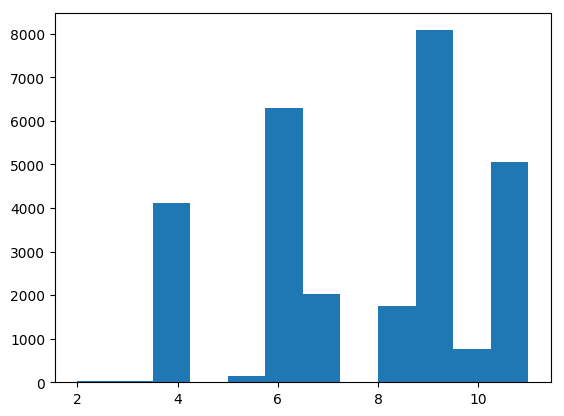

(2, 11)

In [13]:
PyPlot.plt[:hist](Dates.month.(time),12)
extrema(Dates.month.(time))

In [14]:
bathname = "gebco_30sec_16.nc"

if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/o0vinoQutAC7eb0/download",bathname)
else
    info("Bathymetry file already downloaded")
end

bathisglobal = true

# Extract the bathymetry for plotting

lonr = extrema(lon[sel])
latr = extrema(lat[sel])

lonr = -10:30
latr = 30:45 
bx,by,b = extract_bath(bathname,bathisglobal,lonr,latr);



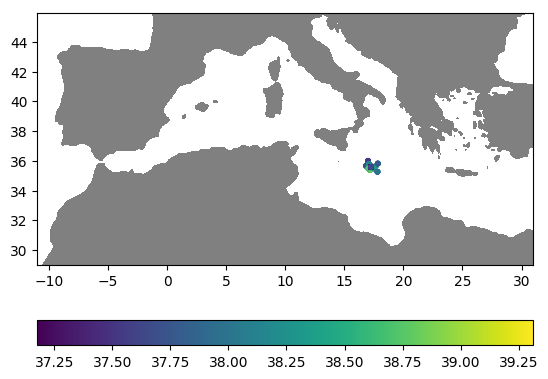

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5be91e3c10>

In [15]:
contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
scatter(lon[sel],lat[sel],10,data[sel])
# compute and set the correct aspect ratio
aspect_ratio = 1/cos(mean(latr) * pi/180)
gca()[:set_aspect](aspect_ratio)
colorbar(orientation = "horizontal")